In [55]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import glob, os
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import librosa
from scipy.io import wavfile
sns.set_style("whitegrid")
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Stimulus Generation

Generate stimuli for looming experiment (Benghanem et al., 2022)\
&copy; JJ Aucouturier, 2021

## Looming sound

Pure tone, duration 500ms, 10dB rise 

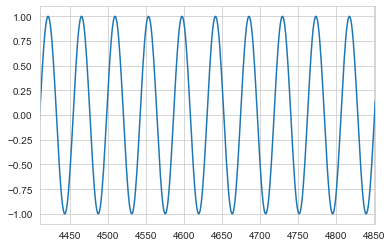

In [62]:
def generate_pure_tone(amplitude, f_zero, duration, sample_rate):
    
    t = np.arange(sample_rate*duration/1000)
    y = (amplitude*np.sin(2*np.pi*f_zero/sample_rate*t)).astype(np.float32)
    return t,y

t,y = generate_pure_tone(amplitude = 1.0,
                         f_zero = 1000,
                         duration = 500,
                         sample_rate = 44100)
    
Audio(data=y, rate=sample_rate)
_=plt.plot(t,y)
_=plt.xlim([0.1*sample_rate,0.11*sample_rate])

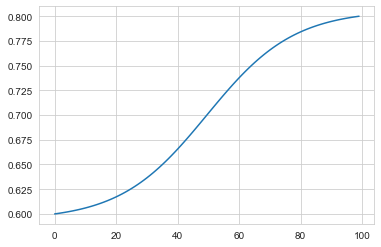

In [27]:
def sigmoid(x_min=0, x_max=100, y_min=-1, y_max=1, n_points=100, slope = 7): 
    
    # sample n_points between x_min and x_max
    x = np.linspace(start=x_min,
                    stop=x_max,
                    num=n_points)
    
    # center sigmoid at midrange
    center= np.median(x)
    
    # scale slope to range 
    slope = slope / (x_max-x_min)
    y = 1 / (1 + np.exp(-slope*(x-center)))
    
    # scale between y_min et y_max
    y = (y_max-y_min)*(y - np.min(y))/(np.max(y)-np.min(y)) + y_min
    
    return y

y = sigmoid(x_min=0,x_max=1,
            y_min = 0.6,y_max=0.8,
            n_points=100,
            slope=7)
plt.plot(y)

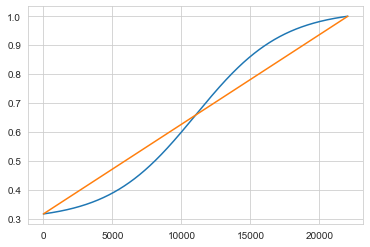

In [85]:
def generate_ramp (decibel = 10,
                   n_points = 100,
                   is_sigmoid = True, slope = 7): 
                       
    # ramp from -decibel dB to 0dB, ie from amplitude: 10^(-decibel/20) to 1.0     
    end_amplitude = 1.0
    start_amplitude =  np.power(10,-decibel/20)

    if is_sigmoid: 
        ramp = sigmoid(x_min = 0,
                       x_max = n_points,
                       y_min = start_amplitude,
                       y_max = end_amplitude,
                       n_points = n_points,
                       slope = slope)
    else:
        # linear ramp
        ramp = np.arange(0,n_points)/n_points*(end_amplitude-start_amplitude) + start_amplitude

    return ramp
    
sigmoid_ramp = generate_ramp (decibel = 10,
                              n_points = len(y),
                              is_sigmoid = True)
linear_ramp = generate_ramp (decibel = 10,
                              n_points = len(y),
                              is_sigmoid = False)

_=plt.plot(sigmoid_ramp)
_=plt.plot(linear_ramp)



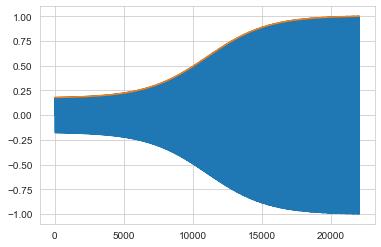

In [87]:
# multiply sine by ramp
t,y = generate_pure_tone(amplitude = 1.0,
                         f_zero = 1000,
                         duration = 500,
                         sample_rate = 44100)

ramp = generate_ramp (decibel = 15,
                      n_points = len(y),
                      is_sigmoid = True, slope = 10)

looming = y*ramp

Audio(data=looming, rate=44100)

_=plt.plot(looming)
_=plt.plot(ramp)
#plt.xlim([0.1*sample_rate,0.11*sample_rate])